# Machine Learning via PyCaret

In [1]:
import pandas as pd                       
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
from pycaret.classification import *

# # To render interactive plots in Google Colab
# from pycaret.utils import enable_colab
# enable_colab()

## Read the dataset

In [2]:
df = pd.read_csv('../data/name_gender.csv') 
df.head()

,name,gender
0,Aaban&&,M
1,Aabha*,F
2,Aabid,M
3,Aabriella,F
4,Aada_,F


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95025 entries, 0 to 95024
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    95025 non-null  object
 1   gender  95025 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [8]:
df.gender.value_counts()

F    60304
M    34721
Name: gender, dtype: int64

<span style="color:black;font-family:Malgun Gothic;font-size:14px;font-weight:bold">keep 2% as unseen data</span>

In [9]:
df.shape

(95025, 2)

In [10]:
unseen_data = df.sample(frac=0.02, random_state=24)
df = df.drop(unseen_data.index).reset_index(drop=True)
#unseen_data.to_csv("../data/sample_test.csv", index=False)

## Preparing Data (and features)

### text preprocessing

In [6]:
# text preprocessing (mainly cleaning)
def preprocessing(name_series):
    # 1. keep alphabets only and 2. (standardize) lowercase names  
    name_series = name_series.str.replace('[^a-zA-Z]', '').str.lower()
    return name_series

In [12]:
df_clean = df.copy()
df_clean["name"] = preprocessing(df_clean["name"])
df_clean.drop_duplicates(inplace=True)

In [13]:
# encode labels into categorical numbers: 0 is F and 1 is M
y = df_clean['gender'].astype("category").cat.codes.values
names = df_clean['name']

In [14]:
print(
    "M : " + str(sum(y==1)),
    "F : " + str(sum(y==0))
)

M : 34020 F : 59105


### Encoding Words
To main character orders, create a feature matrix containing. Also assume maximum length of a name is 25 (reference: [link](https://www.researchgate.net/figure/First-names-and-last-names-lengths-distributions_fig1_328894441))

In [7]:
#word encoding 
maxlen = 25
# creating a vocab and dict map                              
vocab = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
vocab.append("END")
len_vocab = len(vocab)
char_index = {c:i for i, c in enumerate(vocab)}   # creating a dictionary

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab)
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def get_encod_names(X):
    vec_names = []
    trunc_names = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for name in trunc_names:
        tmp = [set_flag(char_index[i]) for i in str(name)]
        for k in range(0,maxlen - len(str(name))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

In [16]:
x = get_encod_names(names.values)

## Split the data into train and test

In [17]:
# train/test: 80/20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=9)
x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)

In [8]:
def data_to_df(x, y=None):
    df_x = pd.DataFrame(data=x.reshape((x.shape[0],-1)))
    y_column = []
    if y is not None and isinstance(y_train,np.ndarray):
        df_y = pd.DataFrame(data=y.reshape((y.shape[0],-1)))
        df = pd.concat([df_x, df_y], axis=1)
        y_column.append('gender')
    else:
        df = df_x
    df.columns = [str(pos+1)+char for pos in range(maxlen) for char in vocab] + y_column
    df = df.astype('int8')
    return df

In [19]:
df_train = data_to_df(x_train, y_train)
df_test = data_to_df(x_test, y_test)

In [20]:
train_size = round(len(df_train)/(len(df)), 2)
test_size = round(len(df_test)/(len(df)), 2)
print(
    "train: "+"{:.1%}".format(train_size), 
    "test: "+"{:.1%}".format(test_size),sep='\n'
)

train: 80.0%
test: 20.0%


In [21]:
df_ = pd.concat([df_train, df_test])

## Train models

In [22]:
session = setup(data=df_, target='gender', silent=True, train_size=0.8, session_id=123)

,Description,Value
0,session_id,123
1,Target,gender
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(93125, 676)"
5,Missing Values,False
6,Numeric Features,675
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [137]:
top_3 = compare_models(n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9006,0.9629,0.8446,0.8786,0.8612,0.7838,0.7842,10.7470
rf,Random Forest Classifier,0.8960,0.9606,0.8325,0.8765,0.8539,0.7732,0.7739,6.4420
knn,K Neighbors Classifier,0.8642,0.9265,0.7613,0.8510,0.8037,0.7003,0.7029,298.2080
lightgbm,Light Gradient Boosting Machine,0.8562,0.9256,0.8003,0.8049,0.8026,0.6895,0.6895,0.9810
dt,Decision Tree Classifier,0.8530,0.8410,0.7966,0.8000,0.7983,0.6826,0.6826,0.7520
lr,Logistic Regression,0.7946,0.8583,0.6635,0.7461,0.7023,0.5464,0.5486,18.8950
svm,SVM - Linear Kernel,0.7898,0.0000,0.6537,0.7475,0.6907,0.5339,0.5413,1.6650
lda,Linear Discriminant Analysis,0.7898,0.8551,0.6498,0.7426,0.6931,0.5344,0.5371,9.0030
ridge,Ridge Classifier,0.7892,0.0000,0.6409,0.7460,0.6895,0.5313,0.5348,1.7720
gbc,Gradient Boosting Classifier,0.7710,0.8647,0.5780,0.7385,0.6480,0.4822,0.4905,8.0160


In [24]:
# # Save the top models
# save_model(top_3, '../model/top_3model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='gender',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
             

In [23]:
# Create an Extra Trees Classifier	
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8991,0.9624,0.8377,0.8809,0.8588,0.7803,0.7809
1,0.8969,0.9623,0.8424,0.8718,0.8569,0.7764,0.7766
2,0.9031,0.9644,0.8428,0.8870,0.8643,0.7890,0.7897
3,0.8995,0.9616,0.8435,0.8773,0.8601,0.7817,0.7820
4,0.9012,0.9628,0.8472,0.8788,0.8627,0.7856,0.7859
5,0.9013,0.9623,0.8527,0.8748,0.8636,0.7864,0.7865
6,0.9055,0.9652,0.8498,0.8875,0.8682,0.7946,0.7951
7,0.8992,0.9625,0.8402,0.8792,0.8593,0.7808,0.7813
8,0.9082,0.9663,0.8637,0.8831,0.8733,0.8013,0.8014


In [136]:
# Create an Extra Trees Classifier	
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8984,0.9613,0.8464,0.8717,0.8588,0.7795,0.7797
1,0.8980,0.9622,0.8401,0.8755,0.8575,0.7781,0.7785
2,0.8997,0.9616,0.8453,0.8759,0.8603,0.7821,0.7824
3,0.8977,0.9623,0.8361,0.8780,0.8566,0.7772,0.7777
4,0.9063,0.9652,0.8508,0.8880,0.8690,0.7961,0.7966
5,0.9024,0.9649,0.8482,0.8802,0.8639,0.7879,0.7882
6,0.9047,0.9627,0.8600,0.8767,0.8683,0.7936,0.7937
7,0.8969,0.9623,0.8342,0.8774,0.8553,0.7753,0.7759
8,0.8999,0.9610,0.8364,0.8832,0.8591,0.7816,0.7822


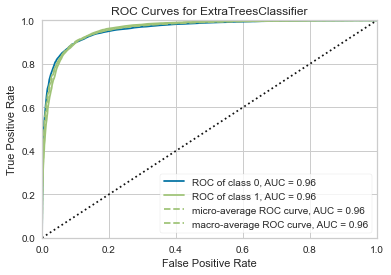

In [31]:
# performance on test/held-out dataset
plot_model(et)

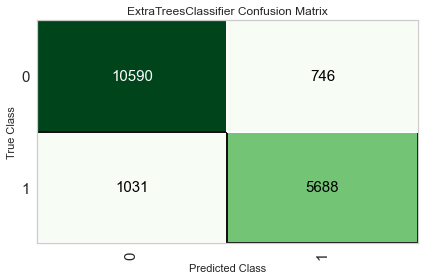

In [32]:
plot_model(et, plot = 'confusion_matrix')

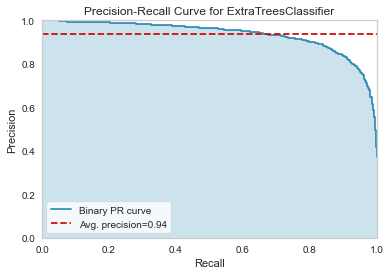

In [34]:
# Precision Recall Curve
plot_model(et, plot = 'pr')

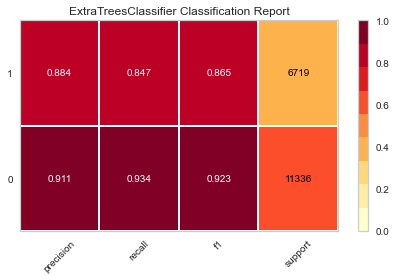

In [33]:
plot_model(et, plot = 'class_report')

- Top 10 features in the ExtraTreeClassifier, e.g., 6a, an letter 'a' at the 6th position of a name

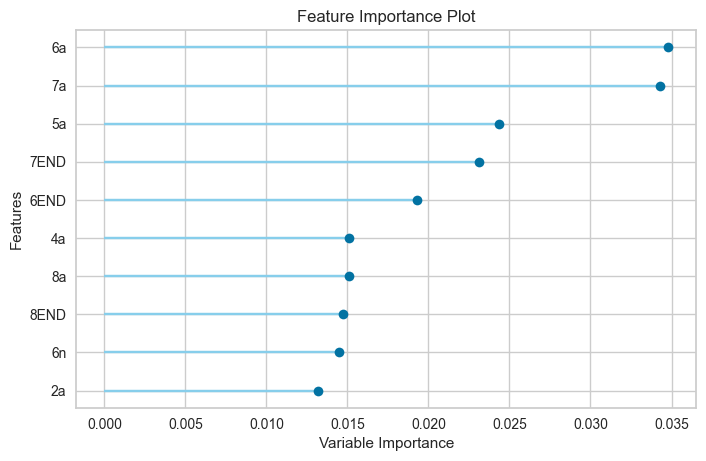

In [35]:
plot_model(et, plot='feature')

In [138]:
# Make predictions on the test set
predict_model(et);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9036,0.9647,0.8494,0.8827,0.8657,0.7906,0.7910


- stacking model based on top 3 models above

In [27]:
stack_soft = stack_models(top_3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9053,0.9663,0.8608,0.8772,0.8689,0.7948,0.7949
1,0.8996,0.9612,0.8615,0.8630,0.8622,0.7833,0.7833
2,0.9075,0.9659,0.8734,0.8731,0.8732,0.8004,0.8004
3,0.9041,0.9663,0.8644,0.8716,0.8680,0.7927,0.7927
4,0.9081,0.9647,0.8665,0.8795,0.8730,0.8009,0.8010
5,0.9086,0.9654,0.8773,0.8726,0.8750,0.8029,0.8029
6,0.9015,0.9635,0.8589,0.8693,0.8641,0.7868,0.7869
7,0.9028,0.9630,0.8654,0.8676,0.8665,0.7901,0.7901
8,0.9063,0.9635,0.8751,0.8689,0.8720,0.7981,0.7982


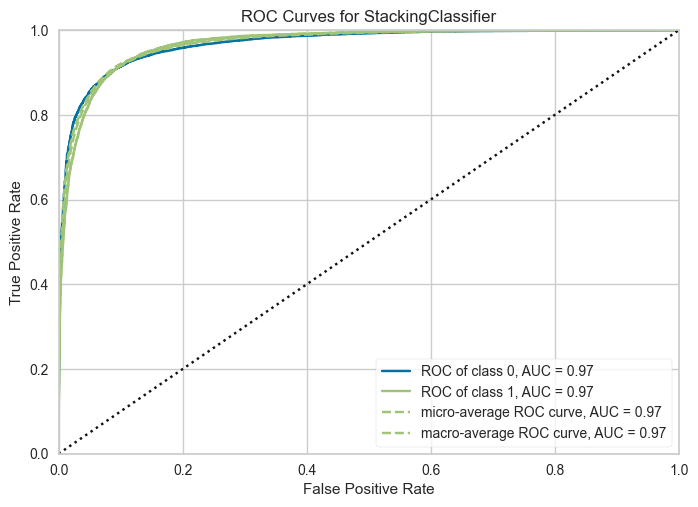

In [28]:
plot_model(stack_soft)

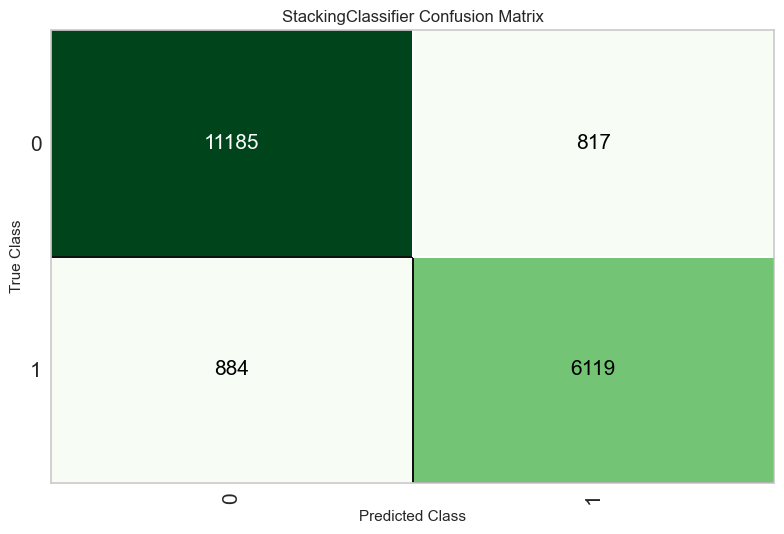

In [30]:
plot_model(stack_soft, plot = 'confusion_matrix')

In [29]:
#save_model(stack_soft, '../model/stack_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='gender',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                                                                       p=2,
                                                                       weights='uniform'))],
                                     final_estimator=LogisticRegression(C=1.0,
                          

In [34]:
# Make predictions on the test set
predict_model(stack_soft);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9105,0.9681,0.8738,0.8822,0.8780,0.8073,0.8073


Given limited improvement on test performance but super long processing time, I decide to use ExtraTreeClassifier.

In [139]:
# Finalize the model
final_mod = finalize_model(et)

In [154]:
save_model(final_mod,'../model/final_extra_tree_classifier')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='gender',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nod

## Load Final Model and Test on Unseen Data

In [4]:
saved_final_mod = load_model('../model/final_extra_tree_classifier')

Transformation Pipeline and Model Successfully Loaded


In [9]:
test_data = pd.read_csv("../data/sample_test.csv")
test_data.iloc[:,0] = preprocessing(test_data.iloc[:,0])
test_x = get_encod_names(test_data.iloc[:,0].values)
test_x_df = data_to_df(np.asarray(test_x))

In [10]:
code_to_label = {0:'F',1:'M'}
test_predictions_res = predict_model(saved_final_mod, data=test_x_df)
test_data["predicted_gender"] = test_predictions_res["Label"].map(code_to_label)

In [11]:
acc = len(test_data.query("gender==predicted_gender"))/len(test_data)
print("predicted accuracy on unseen data:","{:.2%}".format(acc))

predicted accuracy on unseen data: 91.68%


___